In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np
from keras import backend
from keras.layers.merge import _Merge
from functools import partial

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
def wasserstein_loss(y_actual,y_pred):
  return backend.mean(y_actual*y_pred)

In [ ]:
def gradient_penalty_loss(y_actual,y_pred,averaged_samples,gp_weight):
  #get gradients of the predicted output with respect to interpolated samples
  gradients=backend.gradients(y_pred,averaged_samples)[0]
  #find root of sum of squares - normalized gradient value
  gradients_sqr=backend.square(gradients)
  gradients_sqr_sum=backend.sum(gradients_sqr,axis=np.arange(1,len(gradients_sqr.shape)))
  gradients_l2_norm=backend.sqrt(gradients_sqr_sum)
  #get gp based on how much normalized gradients deviate from 1
  gradient_penalty=gp_weight*backend.square(1-gradients_l2_norm)
  return backend.mean(gradient_penalty)

In [ ]:
#generating autoencoder noise corresponding to every image
X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_ISL.pkl','rb'))
X_train = (X_train.astype(np.float32)-127.5)/127.5
encoder=load_model('drive/MyDrive/encoder.h5')
X_train_noise=encoder.predict(X_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)
batch_size=16

In [ ]:
#building a generator
def build_generator():
  noise_shape = (100,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))

  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
class RandomInterpolation(_Merge):
  def _merge_function(self,inputs):
    #get random weights for the current batch
    weights=backend.random_uniform((batch_size,1,1,1))
    #inputs[0] - real images; inputs[1] - fake images
    return (weights*inputs[0])+((1-weights)*inputs[1])

In [ ]:
disc_loss=[]
gen_loss=[]

In [ ]:
def train(epochs,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_ISL.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  n_disc=5
  global d_loss
  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    d_loss_i=[]
    for step in range(n_disc):
      #select random batch of real images
      id=np.random.randint(0,X_train.shape[0],batch_size)
      imgs=X_train[id]
      #get batch of random noise
      idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
      noise=X_train_noise[idn]
      #discriminator loss
      d_loss=combined_disc.train_on_batch([imgs,noise],[np.ones((batch_size,1)),-np.ones((batch_size,1)),np.zeros((batch_size,1))])
      d_loss_i.append(d_loss)
      
    disc_loss.append(np.mean(d_loss_i))
    '''
    train generator
    '''
    idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
    noise=X_train_noise[idn]
    valid_y=np.array([1.0]*batch_size)
    #generator loss
    g_loss=combined_gen.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)

    print(epoch,' ',np.mean(d_loss_i),' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  idn=np.random.randint(0,X_train_noise.shape[0],r*c)
  noise=X_train_noise[idn]
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/WGANGP_images_autoencoder_noise_ISL/ISL%d.png"%epoch)
  generator.save('drive/MyDrive/WGANGP_models_autoencoder_noise_ISL/wgeneratorgp_model_autoencoder_noise_test_ISL%d.h5'%epoch)
  plt.close()

In [ ]:
#choosing the optimizer
optimizer=Adam(0.0001,beta_1=0.9,beta_2=0.9)

#building the discriminator
discriminator=build_discriminator()
#building the generator
generator=build_generator()

#input vector
z=Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined generator model
combined_gen=Model(z,valid)
combined_gen.compile(loss=wasserstein_loss,optimizer=optimizer)

discriminator.trainable=True
generator.trainable=False

#real images
real_samples=Input(shape=img_shape)
#fake images
fake_samples=generator(z)
#interpolated images
averaged_samples=RandomInterpolation()([real_samples,fake_samples])
#discriminator output for three types of samples
d_real=discriminator(real_samples)
d_fake=discriminator(fake_samples)
d_avg=discriminator(averaged_samples)
#initializing gradient penalty loss
partial_gp_loss=partial(gradient_penalty_loss,averaged_samples=averaged_samples,gp_weight=10)
partial_gp_loss.__name__ = 'gradient_penalty'

#building combined discriminator model
combined_disc=Model([real_samples,z],[d_real,d_fake,d_avg])
combined_disc.compile(loss=[wasserstein_loss,wasserstein_loss,partial_gp_loss],optimizer=optimizer)

#training the GAN
train(epochs=10000,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/wgeneratorgp_model_autoencoder_noise_test_ISL.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 80, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 80, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 40, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 40, 128)       0         
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 100)               15360100  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Streaming output truncated to the last 5000 lines.
5001   -9.844697   20.341507
5002   -7.7124214   27.16666
5003   -7.495903   17.541348
5004   -7.416364   20.004086
5005   -8.915743   18.156914
5006   -8.754217   14.90662
5007   -8.448484   17.738577
5008   -8.2484045   17.448452
5009   -7.2283187   14.8998165
5010   -8.6343355   16.8654
5011   -8.318632   20.322964
5012   -7.373835   18.683567
5013   -7.2974114   17.53122
5014   -7.7962236   22.401764
5015   -8.451145   14.740327
5016   -8.460794   14.327489
5017   -7.619292   14.17901
5018   -7.664393   15.405615
5019   -9.246671   17.50895
5020   -8.262039   20.419012
5021   -9.51573   20.117908
5022   -9.312576   14.650467
5023   -8.954458   15.521959
5024   -9.260335   21.342644
5025   -7.03629   21.985508
5026   -7.3874464   20.923653
5027   -7.6784005   15.630948
5028   -8.293225   14.696642
5029   -8.914271   11.759879
5030   -7.0952387   15.027224
5031   -8.245049   16.267145
5032   -7.7610846   16.165298
5033   -8.007685   

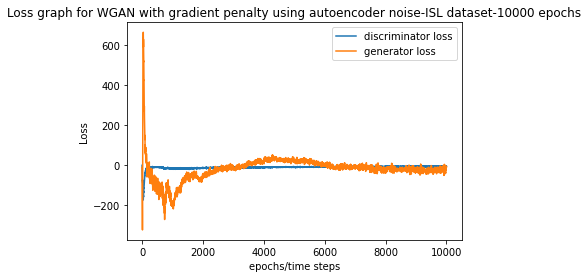

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for WGAN with gradient penalty using autoencoder noise-ISL dataset-10000 epochs')
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


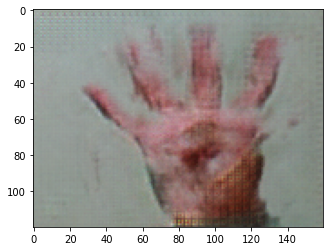

In [ ]:
#Generating random image
from numpy.random import randn
gm=load_model('drive/MyDrive/wgeneratorgp_model_autoencoder_noise_test_ISL.h5')
idn=np.random.randint(0,X_train_noise.shape[0],1)
vector=X_train_noise[idn]
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])